# Exercise 4.3

Consider a linear regression problem with squared loss function. Implement stochastic gradient descent with
- a mini-batch of size 1,
- a larger and larger mini-batch size,
- the whole sample.

Evaluate the result in terms of effectiveness and number of iterations.

## Preamble

In [ ]:
import numpy as np

import matplotlib.pyplot as plt


rng = np.random.default_rng(2025)

## Setup

Simulate `n` data points in `d` dimensions. \
Each observation is given by a linear combination of the predictors perturbed by gaussian noise:

$$ y_i = x_i^\top w^* + \varepsilon_i,\quad \varepsilon_i \sim \mathcal{N}(0,\sigma^2) $$

In [ ]:
n = 500
d = 5
X       = rng.normal(size=(n, d))
w_true  = rng.normal(size=d)
eps     = 0.1 * rng.normal(size=n)
y       = X @ w_true + eps

For each observation the formulas for the loss and its gradient are
$$ l_i(w) = \frac{1}{2} (y_i - x_i^\top w)^2 $$
$$ \nabla l_i(w) = - (y_i - x_i^\top w) x_i $$

So on a batch of size $b$ we average
$$ \nabla L(w) = - \frac{1}{b} \sum_{i=1}^b (y_i - x_i^\top w)x_i $$

In [ ]:
def loss_and_grad(w, X_batch, y_batch):
  preds  = X_batch @ w                        # (bxd) @ (dx1) -> (b,)
  resid  = y_batch - preds
  loss   = 0.5 * np.mean(resid**2)            # average over batch
  grad   = - (resid @ X_batch) / len(resid)   # (1xb) @ (bxd) -> (d,)
  return loss, grad

Loss and gradients are computed one batch at a time. \
Then weights are updated
$$ w \ \leftarrow\  w - \eta\, \nabla L $$
according to the learning parameter $\eta$ .

In [ ]:
def sgd(X, y, batch_size, eta, max_iters):
  n, d = X.shape
  w = np.zeros(d)                # initialize parameters
  history = []                   # to store loss over time

  for _ in range(max_iters):
    idx = rng.choice(n, batch_size, replace=False)    # sample indices (without replacement)
    Xb, yb = X[idx], y[idx]                           # select batch
    loss, grad = loss_and_grad(w, Xb, yb)             # compute loss and gradients
    w -= eta * grad                                   # update parameters
    history.append(loss)                              # add loss

  return w, np.array(history)

## Execution

Plot the loss for various batch sizes, from 1 (pure SGD) to `n` (full batch). \
We record also the final loss and the number of iterations to get close enough to the true loss.

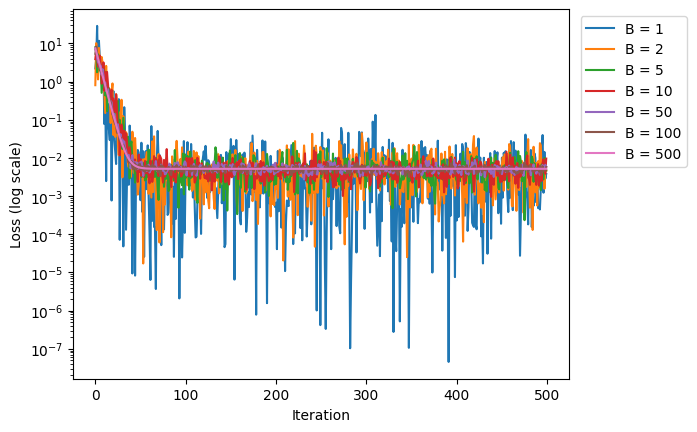

In [ ]:
true_loss = loss_and_grad(w_true, X, y)[0]
tol = (1 + 1e-3) * true_loss
batch_sizes = [1, 2, 5, 10, 50, 100, n]

final_losses, iters_to_tol = [], []

for B in batch_sizes:
  _, hist = sgd(X, y, batch_size=B, eta=0.1, max_iters=500)
  final_losses.append(hist[-1])
  iters_to_tol.append(np.argmax(hist < tol))

  plt.plot(hist, label=f"B = {B}")

plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.show()

Smaller batches give more "unstable" losses, while with the full batch we get a very smooth line.

Number of iterations to get within 0.1% of true loss:
B = 2	: 30
B = 5	: 38
B = 10	: 45
B = 50	: 47
B = 100	: 42
B = 500	: 62


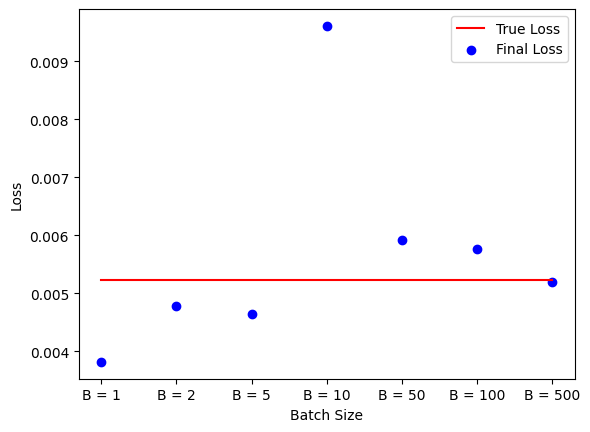

In [ ]:
labels = [f"B = {b}" for b in batch_sizes]

print(f"Number of iterations to get within {1e-3*100}% of true loss:")
for i in range(1, len(batch_sizes)):
  print(labels[i] + "\t:", iters_to_tol[i])


plt.plot   (labels, [true_loss]*len(labels),
            color='red', label="True Loss")
plt.scatter(labels, final_losses,
            color='blue', label="Final Loss")
plt.legend()
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.show()

Smaller batches converge faster at the start, but they slow down afterwards.

The full batch is consistently more accurate (but needs more computation), while for the other there is variability due to choice of batches (as we can see by changing the seed).

# Exercise 4.4

Repeat problem 4.3 with the additional condition on vanishing learning rate
(that is $\eta \to 0$).

## Setup

We choose to reduce $\eta$ according to the following formula
$$ \eta_t = \frac{\eta_0}{1 + \lambda t} $$
where $\eta_0$ is the initial learning rate and $\lambda$ a decay parameter.

In [ ]:
def sgd_vanishing(X, y, batch_size, eta0, decay, max_iters):
  n, d = X.shape
  w = np.zeros(d)
  history = []

  for t in range(max_iters):
    idx = rng.choice(n, batch_size, replace=False)
    Xb, yb = X[idx], y[idx]
    loss, grad = loss_and_grad(w, Xb, yb)
    eta_t = eta0 / (1 + decay * t)      # compute diminishing step-size
    w -= eta_t * grad
    history.append(loss)

  return w, np.array(history)

## Execution

Now we recycle the previous code.

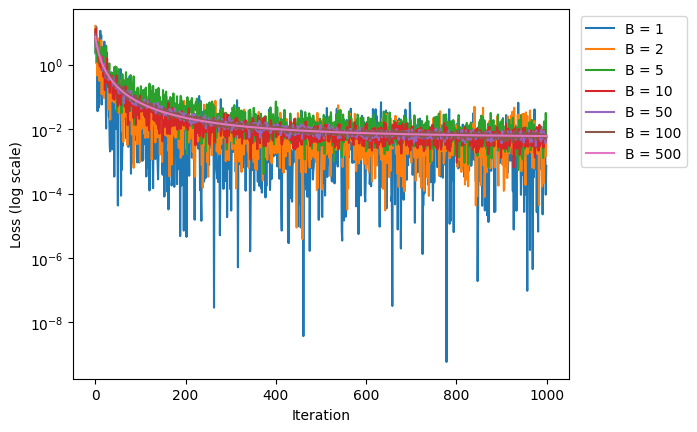

In [ ]:
final_losses, iters_to_tol = [], []

for B in batch_sizes:
  _, hist = sgd_vanishing(X, y, batch_size=B, eta0=0.1, decay=1e-1, max_iters=1000)
  final_losses.append(hist[-1])
  iters_to_tol.append(np.argmax(hist < tol))

  plt.plot(hist, label=f"B = {B}")

plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1))
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.show()

Number of iterations to get within 0.1% of true loss:
B = 2	: 62
B = 5	: 185
B = 10	: 149
B = 50	: 429
B = 100	: 608
B = 500	: 0


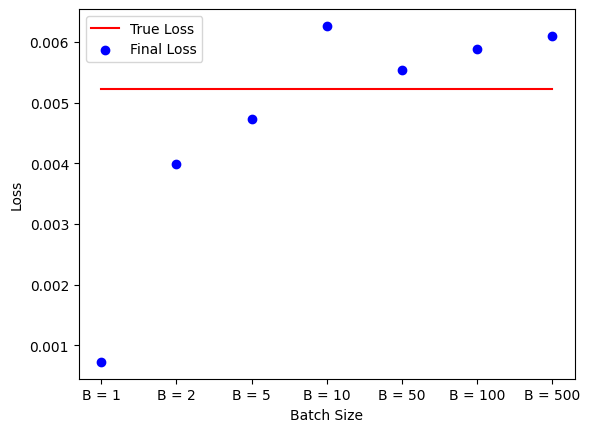

In [ ]:
print(f"Number of iterations to get within {1e-3*100}% of true loss:")
for i in range(1, len(batch_sizes)):
  print(labels[i] + "\t:", iters_to_tol[i])


plt.plot   (labels, [true_loss]*len(labels),
            color='red', label='True Loss')
plt.scatter(labels, final_losses,
            color='blue', label='Final Loss')
plt.legend()
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.show()

With this choice of hyperparameters we see wilder oscillations and more iterations needed to get close to the true loss.

We could try more combinations of values, but I don't have the time :(